In [1]:
import ROOT
%jsroot on

Welcome to JupyROOT 6.10/09


In [13]:
%%bash
ls

bkg_fits
doall.sh
getZa.py
getZa_old.py
loadBDT.py
multiclass_promptness.root
multiclass_promptness_toptag.root
npzfiles
plotFromColumns.py
prep.py
prep2.py
prep_backup.py
rootfiles
test.pdf
testBDT_binary.ipynb
testBDT_multiClass.ipynb
tmva_utils.py
tmva_utils.pyc
train.py
txtfiles
utils.py
utils.pyc
utils_old.py
utils_old.pyc


In [2]:
import numpy
import root_numpy
import pandas
import xgboost
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
import utils
import tmva_utils
import math

f = ROOT.TFile("../Loopers/MVABaby_ttHHadronic_binary_toptag3.root", 'UPDATE')
tree = f.Get("t")

# load tree to array
feature_names = (root_numpy.tree2array(tree, branches = ["mva_branches"], start=0, stop=1))[0][0]
feature_names = list(feature_names) 
#feature_names = feature_names[1:len(feature_names)]
print feature_names

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-elfike/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


['topTag_score_', 'dipho_delta_R', 'njets_', 'ht_', 'leadptoM_', 'subleadptoM_', 'maxIDMVA_', 'minIDMVA_', 'lead_eta_', 'sublead_eta_', 'jet1_pt_', 'jet1_eta_', 'jet1_btag_', 'jet2_pt_', 'jet2_eta_', 'jet2_btag_', 'jet3_pt_', 'jet3_eta_', 'jet3_btag_', 'jet4_pt_', 'jet4_eta_', 'jet4_btag_', 'jet5_pt_', 'jet5_eta_', 'jet5_btag_', 'jet6_pt_', 'jet6_eta_', 'jet6_btag_', 'max1_btag_', 'max2_btag_', 'leadPSV_', 'subleadPSV_', 'dipho_cosphi_', 'dipho_rapidity_', 'met_', 'nb_loose_']


In [25]:
branches = numpy.concatenate((feature_names, ["evt_weight_", "label_", "process_id_", "mass_", "lead_sigmaEOverE_","sublead_sigmaEOverE_"]))
train_frac = 0.5
rand_branch = "rand_" #"super_rand_" if args.randomize else "rand_"
features = root_numpy.tree2array(tree, branches = branches, selection = 'label_ != 2 && %s < %.6f' % (rand_branch, train_frac)) 
features_validation = root_numpy.tree2array(tree, branches = branches, selection = 'label_ != 2 && %s > %.6f' % (rand_branch, train_frac))

#features["topTag_score_"][features["topTag_score_"] == -99] = -1
#features_validation["topTag_score_"][features["topTag_score_"] == -99] = -1

#print features["topTag_score_"]

# organize features
global_features = []
global_features_validation = []
for feature in feature_names:
  global_features.append(features[feature])
  global_features_validation.append(features_validation[feature])
global_features = numpy.asarray(global_features)
global_features_validation = numpy.asarray(global_features_validation)
global_features = numpy.transpose(global_features)
global_features_validation = numpy.transpose(global_features_validation)

label = features["label_"]
weights = features["evt_weight_"]

lead_sigma = features["lead_sigmaEOverE_"]
sublead_sigma = features["sublead_sigmaEOverE_"]
#weights = weights/numpy.sqrt(lead_sigma**2 + sublead_sigma**2)

label_validation = features_validation["label_"]
weights_validation = features_validation["evt_weight_"]
mass_validation = features_validation["mass_"]
processID_validation = features_validation["process_id_"]

print global_features.shape
print label.shape
print weights.shape

print global_features_validation.shape
print label_validation.shape
print weights_validation.shape

(536032, 36)
(536032,)
(536032,)
(539026, 36)
(539026,)
(539026,)


In [26]:
x_train, y_train, weights_train = global_features, label, weights
x_test, y_test, weights_test  = global_features_validation, label_validation, weights_validation

X_train = pandas.DataFrame(data=x_train, columns = feature_names)
X_test = pandas.DataFrame(data=x_test, columns = feature_names)

unique, count =  numpy.unique(label,return_counts=True)
weight1 = utils.sum_of_weights(weights, label, 1)
weight2 = utils.sum_of_weights(weights, label, 0)
sumWeight = weight1 + weight2

#weights_train1 = numpy.multiply(weights_train, numpy.where(label == 1, weight2/weight1, 1) )


d_train = xgboost.DMatrix(X_train, label = y_train, weight = weights_train)
d_test = xgboost.DMatrix(X_test, label = y_test)

sum_pos_weights = utils.sum_of_weights(weights, label, 1)                                                                                                                                                   
sum_neg_weights = utils.sum_of_weights(weights, label, 0)                                                                                                                                                   

print sum_pos_weights, sum_neg_weights

7.4597656518 34708.0822243


In [27]:
#ratio_pos_neg = 0.4
#savename_base = "binary_topTag_sig_1_bkg_2.5"

In [28]:
def Try_sig_bkg_ratio(ratio_pos_neg, savename_base):

    param = { 
            'max_depth': 8,
            'eta': 0.2,
         	'objective': 'binary:logistic',
#	'objective': 'multi:softprob',#'multi:softmax',
#        'num_class': 4,
	        'scale_pos_weight': ratio_pos_neg * sum_neg_weights / sum_pos_weights,
        	'subsample': 1.0,
        	'colsample_bytree': 1.0,
        	'nthread' : 8,
      	    }

    n_round = 100
    evallist = [(d_train, 'train'), (d_test, 'test')]
    progress = {}

# train
    bdt = xgboost.train(param, d_train, n_round, evallist, evals_result = progress)	

# test
    test = bdt.predict(d_test)#, output_margin=True)

    mvaScore = test
    mass2 = numpy.array([mass_validation], dtype = [('mass_', numpy.float64)])
    weight2 = numpy.array([weights_validation], dtype = [('evt_weight_', numpy.float64)])
    label2 = numpy.array([label_validation], dtype = [('label_', numpy.float64)])
    mva1 = numpy.array([mvaScore], dtype = [('mva_score_', numpy.float64)])
    processID = numpy.array([processID_validation], dtype = [('processID_', numpy.int32)])

    hfile = ROOT.TFile("rootfiles/"+savename_base+".root","RECREATE");

    tree_test = root_numpy.array2tree(numpy.transpose(mass2))

    root_numpy.array2tree(numpy.transpose(weight2), tree=tree_test)
    root_numpy.array2tree(numpy.transpose(label2), tree=tree_test)
    root_numpy.array2tree(numpy.transpose(mva1), tree=tree_test)
    root_numpy.array2tree(numpy.transpose(processID), tree=tree_test)

    tree_test.Print()

    hfile.Write()
    hfile.Close()

    #%%bash
    #ls -lrht rootfiles

    # calculate Za
    f_za = ROOT.TFile('rootfiles/'+savename_base+'.root')
    tree_test = f_za.Get("tree")

    var = "mva_score_"
    signal_mva_scores = root_numpy.tree2array(tree_test, branches = [var], selection = "label_ == 1")

    n_quantiles = 100
    quantiles, mva_cut = utils.quantiles_to_mva_score(n_quantiles, signal_mva_scores)

    print "Significance estimate sfor our BDT: s, b_mc, b_data, z_mc, z_data"
    nGrid = 100

    datafile_path = "txtfiles/" + savename_base + ".txt"

    with open(datafile_path, 'w+') as datafile_id:

         for i in range(nGrid):
            selection_base = var + "> %.10f" % ( mva_cut[i][0])#, mva_cut2[n_quantiles2-j-1][0])                                                                                                                
            s,z_mc,z_unc_mc,z_data,z_unc_data = utils.calc_significance2(tree_test, selection_base, i, mva_cut[i][0], 'dummy')
            datafile_id.write(str(s) + ' ' + str(z_mc) + ' ' + str(z_unc_mc) + '\n')                                                                                                                                     

    datafile_id.close()

In [29]:
for i in [1]: #0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]:
    #Try_sig_bkg_ratio(i, "binary_topTag_sig_1_bkg_" + str(i) )
    Try_sig_bkg_ratio(i, "weightedByReso_binary_topTag_sig_1_bkg_" + str(i) )

[0]	train-error:0.144141	test-error:0.197298
[1]	train-error:0.138333	test-error:0.191399
[2]	train-error:0.133157	test-error:0.188887
[3]	train-error:0.132501	test-error:0.188889
[4]	train-error:0.131182	test-error:0.188087
[5]	train-error:0.130936	test-error:0.187572
[6]	train-error:0.129813	test-error:0.187167
[7]	train-error:0.128405	test-error:0.186149
[8]	train-error:0.127159	test-error:0.185481
[9]	train-error:0.125938	test-error:0.184631
[10]	train-error:0.123916	test-error:0.18334
[11]	train-error:0.123286	test-error:0.183017
[12]	train-error:0.12255	test-error:0.182353
[13]	train-error:0.121577	test-error:0.181635
[14]	train-error:0.119949	test-error:0.180424
[15]	train-error:0.118948	test-error:0.179691
[16]	train-error:0.117715	test-error:0.178761
[17]	train-error:0.116927	test-error:0.178346
[18]	train-error:0.116348	test-error:0.177756
[19]	train-error:0.115864	test-error:0.177103
[20]	train-error:0.115555	test-error:0.176988
[21]	train-error:0.115083	test-error:0.176847


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-elfike/lib/python2.7/site-packages/scipy/optimize/minpack.py:713: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-elfike/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0 0.1422249488 0.755733949432 0.522022330236
1 0.2488936604 0.73815784034 0.139762183666
2 0.389105992 0.803598407063 0.102273387521
3 0.516571748 0.72740738867 0.101837101394
4 0.630620056 0.88129010482 0.129249995461
5 0.7285674264 0.937556469391 0.120531592062
6 0.8392613724 0.899564345636 0.0965170705345
7 0.9633727664 0.906814731964 0.0848763438461
8 1.0606492644 0.898152069208 0.0807058809839
9 1.1793936792 0.906248899041 0.07701747077
10 1.2921002424 0.915906364868 0.0747679999259
11 1.4235912328 0.944449152745 0.0730365761632
12 1.5584365852 0.998987083155 0.0770059593223
13 1.6885858308 1.00587190751 0.071828239439
14 1.8133680972 1.02516920565 0.0675863053212
15 1.9213785536 1.03667941188 0.0677551930634
16 2.0367686064 1.07514773967 0.0684191705992
17 2.13001987 1.08015754722 0.0651052029515
18 2.2413846884 1.07436212194 0.0628560793848
19 2.3701921892 1.09162423063 0.0633811387808
20 2.4802152628 1.10005074943 0.0617522299583
21 2.5855422296 1.12104083179 0.0619207814674
22

[09:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[09:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[09:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[09:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[09:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[09:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[09:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[09:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[09:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned no

In [4]:
%matplotlib inline
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt


[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1.2116342117400001, 1.2013376769399999, 1.16169582462, 1.22369094306, 1.21873126, 1.2395849108400001, 1.1844963605000001, 1.21375802539, 1.22367636995, 1.12672176698, 1.2199043940500001, 1.17777310307, 1.0796261950399999, 1.0457550924500001, 1.0611731305500001, 1.0346492497399999, 1.02888784195, 1.0452941679500001, 1.0592449031, 1.04967852241]


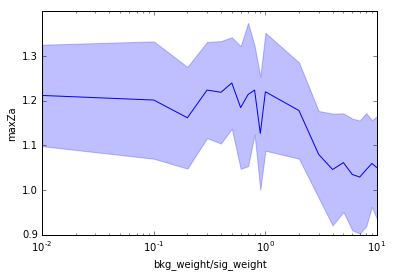

In [17]:
ratios = []
maxZa = []
maxZa_unc = []

for i in [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10]:
#for i in [0.5,1,2]:
    ratios.append(i)
    zaFile = numpy.loadtxt("txtfiles/binary_topTag_sig_1_bkg_" + str(i) + ".txt", usecols=(1,2), unpack=True)
    maxZa.append(numpy.nanmax(zaFile[0]))
    maxZa_unc.append(numpy.nanmax(zaFile[1]))
print ratios
print maxZa

x = numpy.array(ratios)
y = numpy.array(maxZa)
y_unc = numpy.array(maxZa_unc)

plt.fill_between(x, y - y_unc, y + y_unc, color = 'blue', alpha = 0.25)                                          
plt.semilogx(x,y)

plt.xlabel("bkg_weight/sig_weight")
plt.ylabel("maxZa")
#plt.show()
#plt.savefig("/home/users/hmei/public_html/2018/20181018_ttH_had/maxZa_sig_bkg_ratio.png")
plt.savefig("/home/users/hmei/public_html/2018/20181018_ttH_had/maxZa_sig_bkg_ratio.pdf")

In [19]:
def prepareInputs(inputs, colors, styles, keysForPlot, txtfiles, colorlists, linestyles):
    for i in range(len(keysForPlot)):
        inputs[keysForPlot[i]] = numpy.loadtxt(txtfiles[i], usecols=(0,1,2), unpack=True)
        colors[keysForPlot[i]] = colorlists[i]
        styles[keysForPlot[i]] = linestyles[i]


{'sig_1_bkg_1': 'black', 'weighted_sig_1_bkg_1': 'blue', 'sig_1_bkg_0.1': 'm', 'sig_1_bkg_0.2': 'c', 'sig_1_bkg_0.3': 'r', 'sig_1_bkg_0.4': 'g', 'sig_1_bkg_0.5': 'blue', 'sig_1_bkg_0.6': 'm', 'sig_1_bkg_0.7': 'c', 'sig_1_bkg_0.8': 'r', 'sig_1_bkg_0.9': 'g'} {'sig_1_bkg_1': '-', 'weighted_sig_1_bkg_1': '--', 'sig_1_bkg_0.1': '--', 'sig_1_bkg_0.2': '--', 'sig_1_bkg_0.3': '--', 'sig_1_bkg_0.4': '--', 'sig_1_bkg_0.5': '-', 'sig_1_bkg_0.6': '-', 'sig_1_bkg_0.7': '-', 'sig_1_bkg_0.8': '-', 'sig_1_bkg_0.9': '-'}
sig_1_bkg_1
sig_1_bkg_1
sig_1_bkg_0.9
sig_1_bkg_0.8
sig_1_bkg_0.7
sig_1_bkg_0.6
sig_1_bkg_0.5
sig_1_bkg_0.4
sig_1_bkg_0.3
sig_1_bkg_0.2
sig_1_bkg_0.1
weighted_sig_1_bkg_1
weighted_sig_1_bkg_1


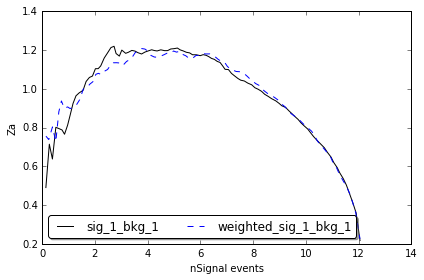

In [29]:

keysForPlot = ["sig_1_bkg_1", "sig_1_bkg_0.9", "sig_1_bkg_0.8", "sig_1_bkg_0.7", "sig_1_bkg_0.6", "sig_1_bkg_0.5",
               "sig_1_bkg_0.4", "sig_1_bkg_0.3", "sig_1_bkg_0.2", "sig_1_bkg_0.1"]
txtfiles = ["txtfiles/binary_topTag_sig_1_bkg_1.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.9.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.8.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.7.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.6.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.5.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.4.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.3.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.2.txt",
            "txtfiles/binary_topTag_sig_1_bkg_0.1.txt"]

colorlists = ["black", "g", "r", "c", "m", "blue", "g", "r", "c", "m", "blue"]
linestyles = ["-","-","-","-","-","-","--","--","--","--","--"]

keysForPlot.append("weighted_sig_1_bkg_1")
txtfiles.append("txtfiles/weightedByReso_binary_topTag_sig_1_bkg_1.txt")
colorlists.append("r")
linestyles.append("--")

inputs = {}
colors = {}
styles = {}

prepareInputs(inputs, colors, styles, keysForPlot, txtfiles, colorlists, linestyles)

print colors, styles

fig = plt.figure()
fig, ax1 = plt.subplots()

for key in keysForPlot:
  print key
  if "sig_1_bkg_1" in key:
    print key
    ax1.plot(inputs[key][0], inputs[key][1], color=colors[key], label=key, linestyle = styles[key])
    #linestyle = '--', dashes = (5,2)

ax1.legend(loc="lower left", #bbox_to_anchor=[0, 1],                                                                                                                                                        
           ncol=2, shadow=True, fancybox=True)
ax1.set_xlabel('nSignal events')
ax1.set_ylabel('Za')


fig.tight_layout()
#plt.show() 
#plt.savefig("/home/users/hmei/public_html/2018/20181018_ttH_had/maxZa_sig_bkg_ratio_full.png")
plt.savefig("/home/users/hmei/public_html/2018/20181018_ttH_had/maxZa_sig_bkg_ratio_full_reso.pdf")